# Neural Network Prediction of Van der Pol Oscillator Dynamics

**Team 19**: Vlad-Flavius Misăilă, Robert-Daniel Man, Sebastian-Adrian Mărginean

## Overview

The Van der Pol oscillator is a nonlinear oscillator with nonlinear damping that exhibits limit cycle behavior:

$$
\frac{d^2x}{dt^2} - \mu(1 - x^2)\frac{dx}{dt} + x = 0
$$

As a first-order system:
$$
\begin{align}
\frac{dx}{dt} &= y \\
\frac{dy}{dt} &= \mu(1 - x^2)y - x
\end{align}
$$

**Standard parameter**: $\mu = 2.0$ (moderate nonlinearity)

**Objective**: Train neural networks to predict future states using only observed time-series data. Unlike chaotic systems, this oscillator exhibits stable limit cycles.

## 1. Setup and Imports

In [3]:
import sys
import os

# Add parent directory to path to import src modules
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Import our custom modules
from src.dynamical_systems import VanDerPolOscillator
from src.data_preparation import generate_trajectory, create_sequences
from src.neural_models import FeedForwardPredictor, LSTMPredictor, GRUPredictor, NeuralPredictor
from src.evaluation import (
    evaluate_prediction, plot_trajectory_3d, plot_time_series,
    plot_prediction_error, plot_training_history, prediction_horizon_analysis
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print("✓ All imports successful!")
print(f"✓ Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ All imports successful!
✓ Using device: cpu


## 2. Generate Van der Pol Oscillator Data

In [4]:
# Initialize Van der Pol oscillator with standard parameters
vdp = VanDerPolOscillator(mu=2.0)

# Generate trajectory
print("Generating Van der Pol oscillator trajectory...")
initial_state = np.array([2.0, 0.0])
t, trajectory = generate_trajectory(
    vdp,
    initial_state=initial_state,
    t_span=(0, 100),  # 100 time units
    dt=0.01,          # Small time step for accuracy
    noise_std=0.0     # No noise initially
)

print(f"✓ Generated {len(t)} time points")
print(f"✓ Trajectory shape: {trajectory.shape}")
print(f"✓ Time range: [{t[0]:.2f}, {t[-1]:.2f}]")

Generating Van der Pol oscillator trajectory...
✓ Generated 10000 time points
✓ Trajectory shape: (10000, 2)
✓ Time range: [0.00, 99.99]


## 3. Visualize the Van der Pol Phase Space

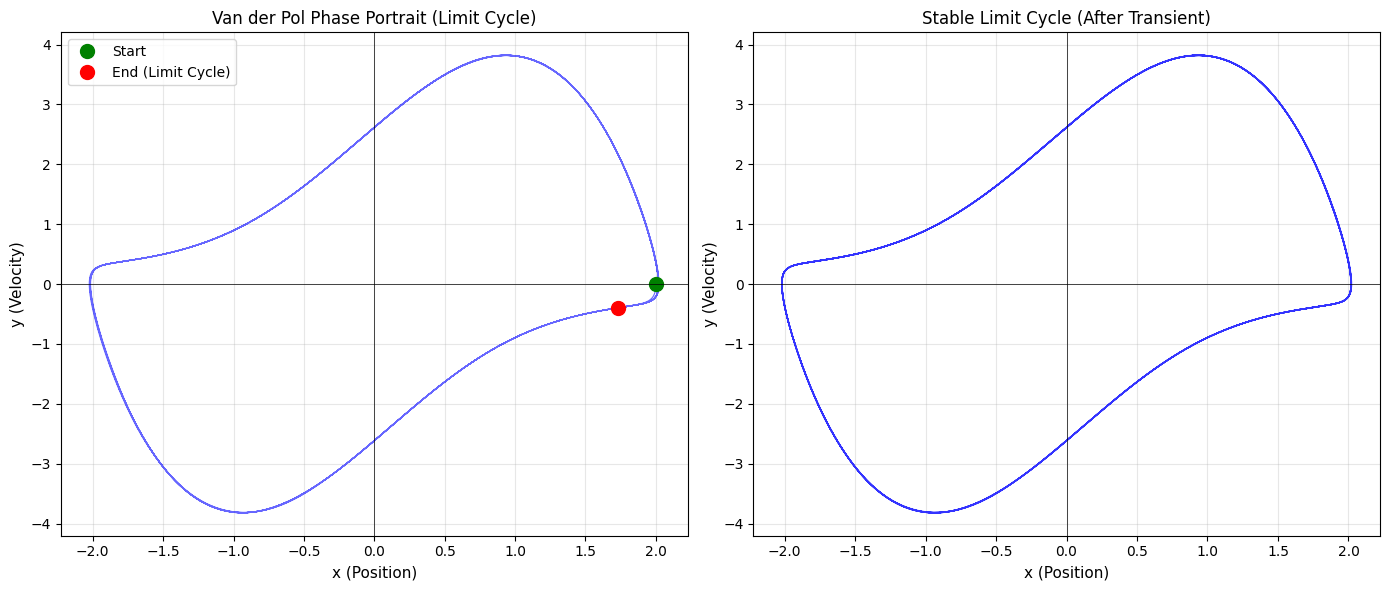

In [5]:
# 2D phase space visualization (Van der Pol is a 2D system)
fig = plt.figure(figsize=(14, 6))

# Phase portrait
ax1 = fig.add_subplot(121)
ax1.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.6, linewidth=0.8)
ax1.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Start')
ax1.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=10, label='End (Limit Cycle)')
ax1.set_xlabel('x (Position)', fontsize=11)
ax1.set_ylabel('y (Velocity)', fontsize=11)
ax1.set_title('Van der Pol Phase Portrait (Limit Cycle)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axhline(0, color='k', linewidth=0.5)
ax1.axvline(0, color='k', linewidth=0.5)

# Zoomed view of limit cycle (after transient)
ax2 = fig.add_subplot(122)
start_idx = 5000  # Skip transient
ax2.plot(trajectory[start_idx:, 0], trajectory[start_idx:, 1], 'b-', alpha=0.8, linewidth=1)
ax2.set_xlabel('x (Position)', fontsize=11)
ax2.set_ylabel('y (Velocity)', fontsize=11)
ax2.set_title('Stable Limit Cycle (After Transient)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='k', linewidth=0.5)
ax2.axvline(0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

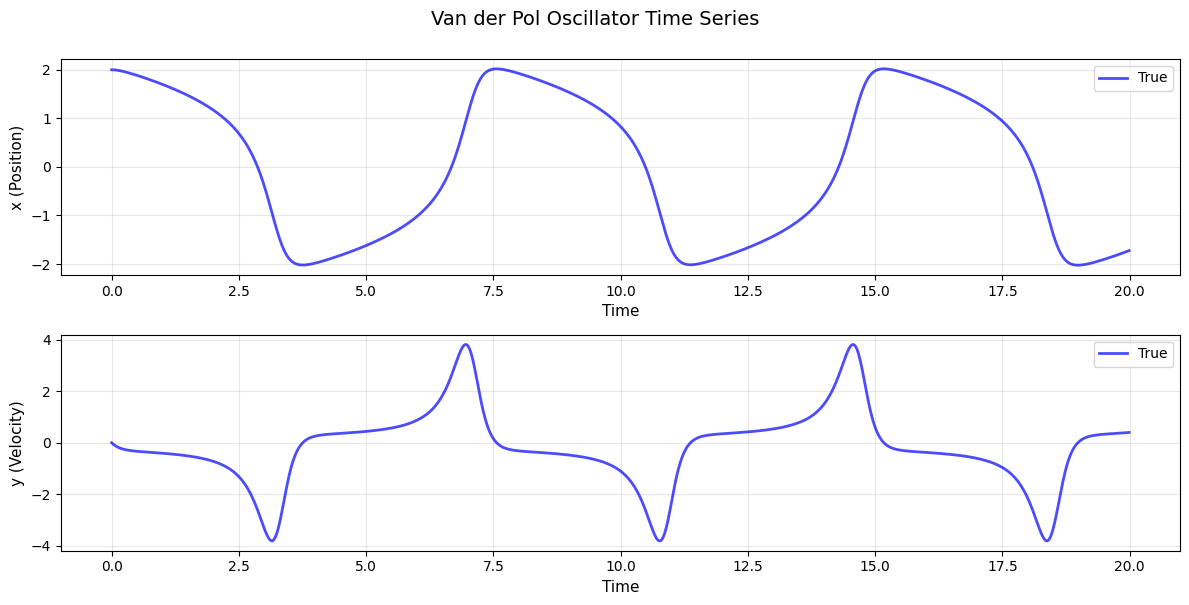

In [6]:
# Time series visualization
plot_time_series(
    t[:2000],  # Plot first 2000 points for clarity
    trajectory[:2000],
    feature_names=['x (Position)', 'y (Velocity)'],
    title='Van der Pol Oscillator Time Series'
)

## 4. Prepare Training Data

We use a sliding window approach:
- **Input**: Past `window_size` states
- **Output**: Next state (1 step ahead)
- **Split**: 80% training, 20% testing (sequential split)

In [7]:
# Hyperparameters
WINDOW_SIZE = 50
PREDICTION_HORIZON = 1
TRAIN_RATIO = 0.8

# Create sequences
print("Preparing training data...")
X_train, y_train, X_test, y_test, scaler = create_sequences(
    trajectory,
    window_size=WINDOW_SIZE,
    prediction_horizon=PREDICTION_HORIZON,
    train_ratio=TRAIN_RATIO,
    normalize=True,
    normalization_method='standard'
)

print(f"✓ Training set: X={X_train.shape}, y={y_train.shape}")
print(f"✓ Testing set: X={X_test.shape}, y={y_test.shape}")
print(f"✓ Input features per sample: {WINDOW_SIZE * 2} (window={WINDOW_SIZE} × dims=2)")

Preparing training data...
✓ Training set: X=(7960, 50, 2), y=(7960, 2)
✓ Testing set: X=(1990, 50, 2), y=(1990, 2)
✓ Input features per sample: 100 (window=50 × dims=2)


## 5. Train Feed-Forward Neural Network

In [8]:
# Create Feed-Forward model
print("\n" + "="*60)
print("Training Feed-Forward Neural Network")
print("="*60)

fnn_model = FeedForwardPredictor(
    input_dim=WINDOW_SIZE * 2,  # Flatten window
    hidden_dims=[128, 64, 32],  # Three hidden layers
    output_dim=2,                # Predict 2D state
    dropout=0.1
)

fnn_predictor = NeuralPredictor(fnn_model, learning_rate=0.001)

# Train model
fnn_history = fnn_predictor.train(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=100,
    batch_size=64,
    verbose=True
)

print("\n✓ Training complete!")


Training Feed-Forward Neural Network


Training: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s, train_loss=0.017008, val_loss=0.001062]


✓ Training complete!


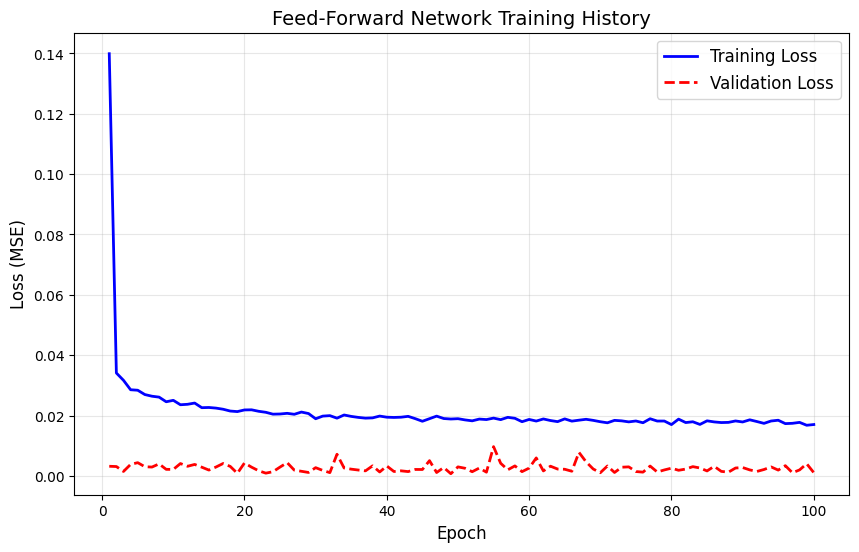

In [9]:
# Plot training history
plot_training_history(fnn_history, title='Feed-Forward Network Training History')

## 6. Train LSTM Network

In [10]:
# Create LSTM model
print("\n" + "="*60)
print("Training LSTM Network")
print("="*60)

lstm_model = LSTMPredictor(
    input_dim=2,          # 2D state at each time step
    hidden_dim=64,        # LSTM hidden dimension
    num_layers=2,         # 2 LSTM layers
    output_dim=2,         # Predict 2D state
    dropout=0.1
)

lstm_predictor = NeuralPredictor(lstm_model, learning_rate=0.001)

# Train model
lstm_history = lstm_predictor.train(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=100,
    batch_size=64,
    verbose=True
)

print("\n✓ Training complete!")


Training LSTM Network


Training: 100%|██████████| 100/100 [05:41<00:00,  3.42s/it, train_loss=0.000141, val_loss=0.000136]


✓ Training complete!


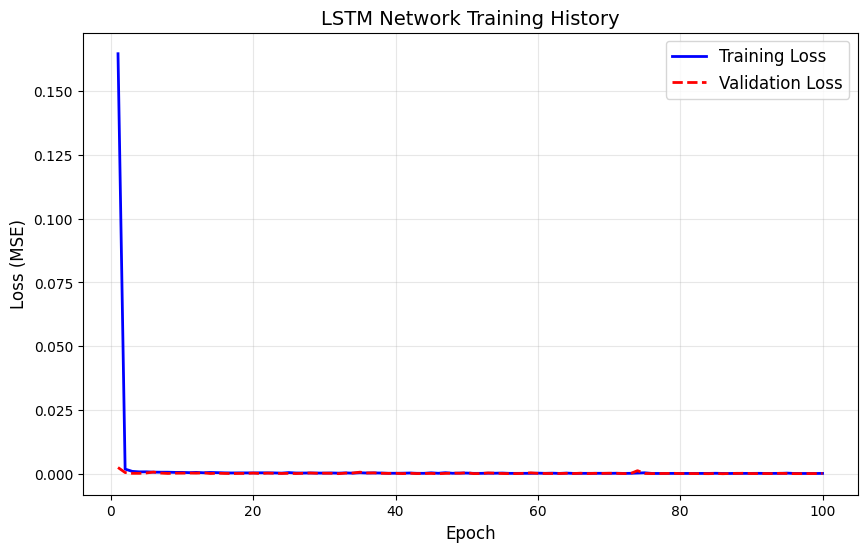

In [11]:
# Plot training history
plot_training_history(lstm_history, title='LSTM Network Training History')

## 7. Evaluate Models: One-Step Prediction

In [12]:
# Make predictions
fnn_predictions = fnn_predictor.predict(X_test)
lstm_predictions = lstm_predictor.predict(X_test)

# Evaluate
fnn_metrics = evaluate_prediction(y_test, fnn_predictions)
lstm_metrics = evaluate_prediction(y_test, lstm_predictions)

print("\n" + "="*60)
print("ONE-STEP PREDICTION RESULTS")
print("="*60)

print("\nFeed-Forward Network:")
print(f"  RMSE:  {fnn_metrics['rmse']:.6f}")
print(f"  MAE:   {fnn_metrics['mae']:.6f}")
print(f"  NRMSE: {fnn_metrics['nrmse']:.6f}")

print("\nLSTM Network:")
print(f"  RMSE:  {lstm_metrics['rmse']:.6f}")
print(f"  MAE:   {lstm_metrics['mae']:.6f}")
print(f"  NRMSE: {lstm_metrics['nrmse']:.6f}")

print("\n" + "="*60)


ONE-STEP PREDICTION RESULTS

Feed-Forward Network:
  RMSE:  0.032590
  MAE:   0.024485
  NRMSE: 0.006294

LSTM Network:
  RMSE:  0.011649
  MAE:   0.009048
  NRMSE: 0.002250



## 8. Visualize Predictions

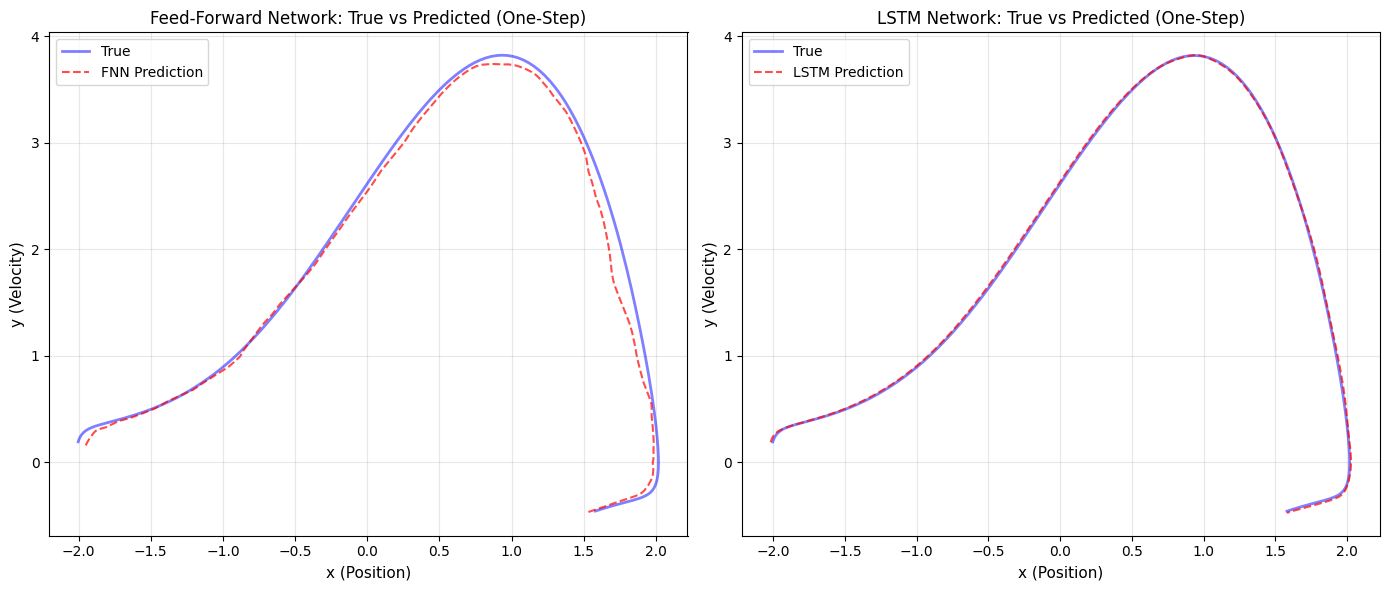

In [13]:
# Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test)
fnn_pred_original = scaler.inverse_transform(fnn_predictions)
lstm_pred_original = scaler.inverse_transform(lstm_predictions)

# Plot phase space predictions for a subset
n_plot = 500
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Feed-Forward predictions
axes[0].plot(y_test_original[:n_plot, 0], y_test_original[:n_plot, 1], 
             'b-', linewidth=2, alpha=0.5, label='True')
axes[0].plot(fnn_pred_original[:n_plot, 0], fnn_pred_original[:n_plot, 1], 
             'r--', linewidth=1.5, alpha=0.7, label='FNN Prediction')
axes[0].set_xlabel('x (Position)', fontsize=11)
axes[0].set_ylabel('y (Velocity)', fontsize=11)
axes[0].set_title('Feed-Forward Network: True vs Predicted (One-Step)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# LSTM predictions
axes[1].plot(y_test_original[:n_plot, 0], y_test_original[:n_plot, 1], 
             'b-', linewidth=2, alpha=0.5, label='True')
axes[1].plot(lstm_pred_original[:n_plot, 0], lstm_pred_original[:n_plot, 1], 
             'r--', linewidth=1.5, alpha=0.7, label='LSTM Prediction')
axes[1].set_xlabel('x (Position)', fontsize=11)
axes[1].set_ylabel('y (Velocity)', fontsize=11)
axes[1].set_title('LSTM Network: True vs Predicted (One-Step)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Multi-Step Iterative Prediction

Test how well the models can predict multiple steps into the future by using their own predictions as input.

In [14]:
# Select an initial window from test set
test_idx = 0
initial_window = X_test[test_idx]
n_future_steps = 200

# True future trajectory
true_future = y_test[test_idx:test_idx + n_future_steps]

# Make iterative predictions
print(f"Making {n_future_steps}-step iterative predictions...")
fnn_future = fnn_predictor.iterative_predict(initial_window, n_future_steps)
lstm_future = lstm_predictor.iterative_predict(initial_window, n_future_steps)

print("✓ Predictions complete")

Making 200-step iterative predictions...
✓ Predictions complete


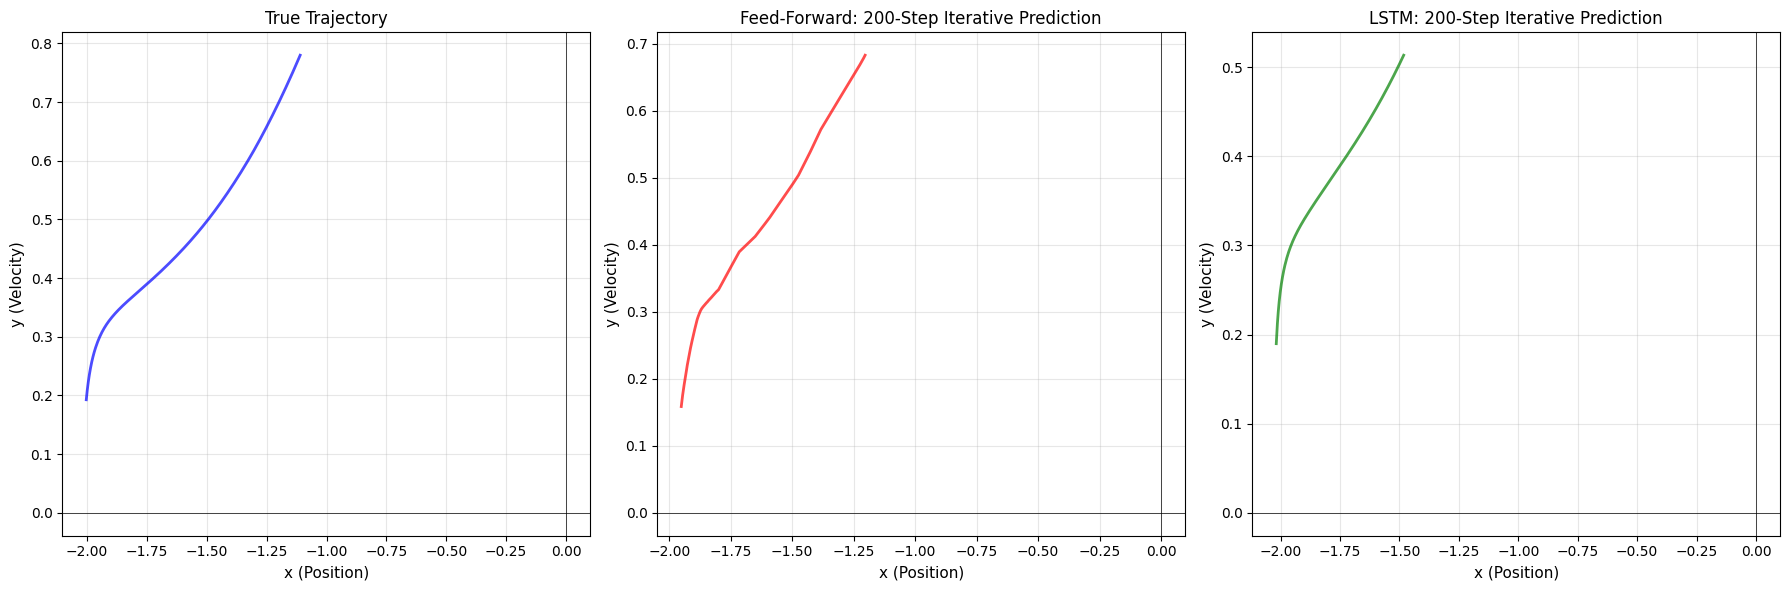

In [15]:
# Inverse transform
true_future_orig = scaler.inverse_transform(true_future)
fnn_future_orig = scaler.inverse_transform(fnn_future)
lstm_future_orig = scaler.inverse_transform(lstm_future)

# Visualize multi-step predictions in phase space
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# True trajectory
axes[0].plot(true_future_orig[:, 0], true_future_orig[:, 1], 'b-', linewidth=2, alpha=0.7)
axes[0].set_xlabel('x (Position)', fontsize=11)
axes[0].set_ylabel('y (Velocity)', fontsize=11)
axes[0].set_title('True Trajectory', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)

# FNN prediction
axes[1].plot(fnn_future_orig[:, 0], fnn_future_orig[:, 1], 'r-', linewidth=2, alpha=0.7)
axes[1].set_xlabel('x (Position)', fontsize=11)
axes[1].set_ylabel('y (Velocity)', fontsize=11)
axes[1].set_title(f'Feed-Forward: {n_future_steps}-Step Iterative Prediction', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].axvline(0, color='k', linewidth=0.5)

# LSTM prediction
axes[2].plot(lstm_future_orig[:, 0], lstm_future_orig[:, 1], 'g-', linewidth=2, alpha=0.7)
axes[2].set_xlabel('x (Position)', fontsize=11)
axes[2].set_ylabel('y (Velocity)', fontsize=11)
axes[2].set_title(f'LSTM: {n_future_steps}-Step Iterative Prediction', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='k', linewidth=0.5)
axes[2].axvline(0, color='k', linewidth=0.5)

plt.tight_layout()
plt.show()

## 10. Prediction Horizon Analysis

Analyze how prediction error grows with prediction horizon (should be slower than chaotic systems).

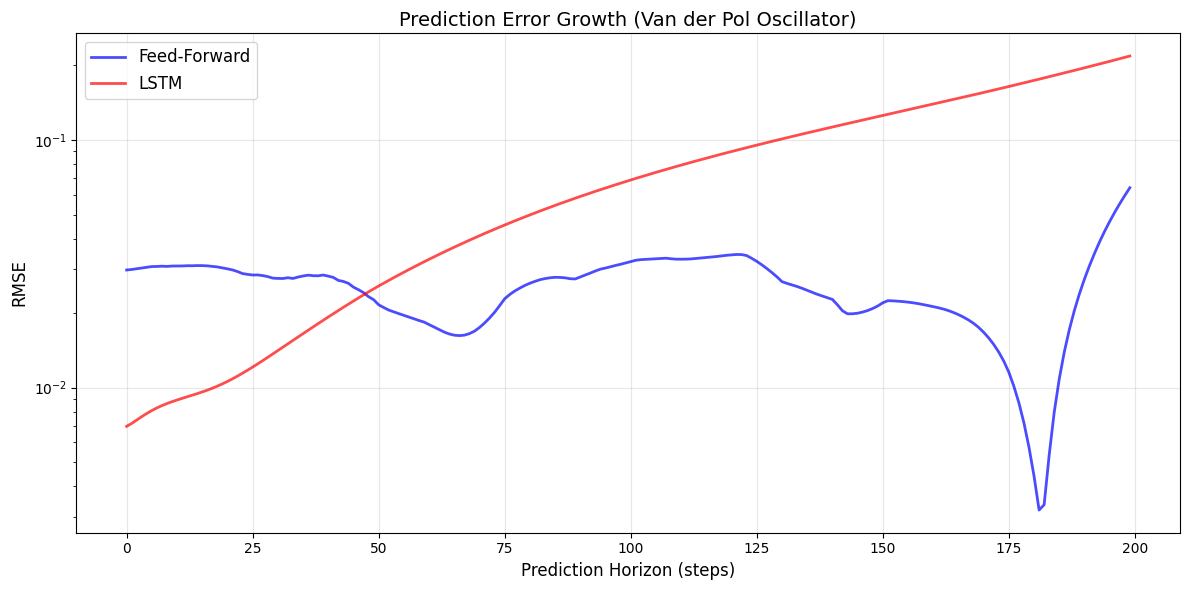

In [16]:
# Analyze prediction horizon
fnn_errors, steps = prediction_horizon_analysis(
    fnn_predictor, initial_window, true_future, max_steps=n_future_steps
)

lstm_errors, _ = prediction_horizon_analysis(
    lstm_predictor, initial_window, true_future, max_steps=n_future_steps
)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(steps, fnn_errors, 'b-', linewidth=2, label='Feed-Forward', alpha=0.7)
ax.plot(steps, lstm_errors, 'r-', linewidth=2, label='LSTM', alpha=0.7)
ax.set_xlabel('Prediction Horizon (steps)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Prediction Error Growth (Van der Pol Oscillator)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## 11. Sensitivity to Noise

Test model robustness by adding noise to the training data.

Testing with noisy data...

Noise level: 0.0
  FNN RMSE:  0.011642
  LSTM RMSE: 0.005364

Noise level: 0.01
  FNN RMSE:  0.010930
  LSTM RMSE: 0.007749

Noise level: 0.05
  FNN RMSE:  0.044328
  LSTM RMSE: 0.036443

Noise level: 0.1
  FNN RMSE:  0.075840
  LSTM RMSE: 0.072842


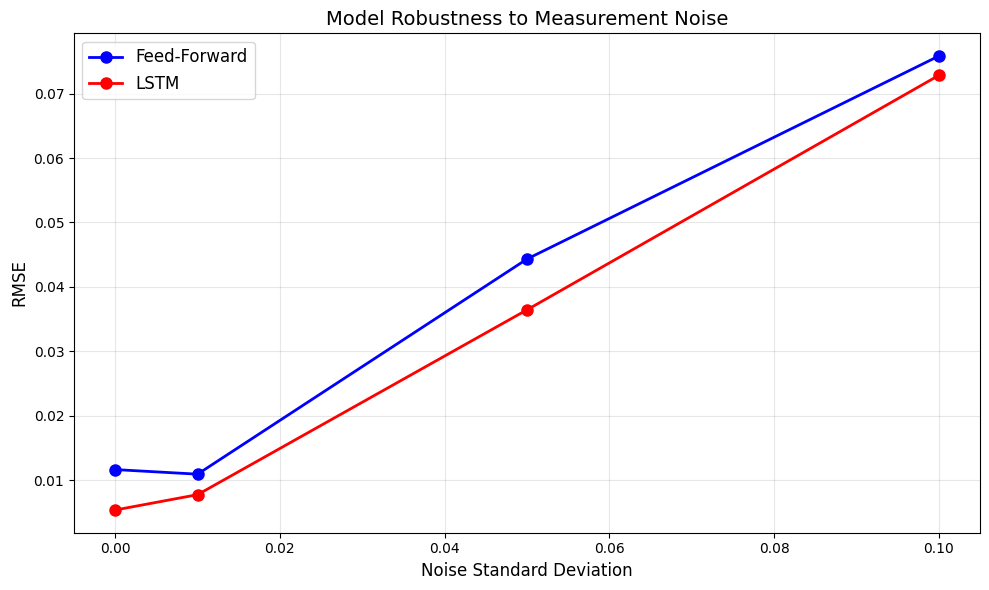

In [17]:
# Generate noisy trajectory
print("Testing with noisy data...")
noise_levels = [0.0, 0.01, 0.05, 0.1]
noise_results = {'fnn': [], 'lstm': []}

for noise_std in noise_levels:
    print(f"\nNoise level: {noise_std}")
    
    # Generate noisy trajectory
    _, noisy_traj = generate_trajectory(
        vdp, initial_state, t_span=(0, 100), dt=0.01, noise_std=noise_std
    )
    
    # Prepare data
    X_tr, y_tr, X_te, y_te, _ = create_sequences(
        noisy_traj, WINDOW_SIZE, PREDICTION_HORIZON, TRAIN_RATIO, normalize=True
    )
    
    # Train quick models (fewer epochs)
    fnn_temp = NeuralPredictor(
        FeedForwardPredictor(WINDOW_SIZE * 2, [64, 32], 2), learning_rate=0.001
    )
    fnn_temp.train(X_tr, y_tr, epochs=30, verbose=False)
    
    lstm_temp = NeuralPredictor(
        LSTMPredictor(2, 32, 2, 2), learning_rate=0.001
    )
    lstm_temp.train(X_tr, y_tr, epochs=30, verbose=False)
    
    # Evaluate
    fnn_pred = fnn_temp.predict(X_te)
    lstm_pred = lstm_temp.predict(X_te)
    
    fnn_rmse = evaluate_prediction(y_te, fnn_pred)['rmse']
    lstm_rmse = evaluate_prediction(y_te, lstm_pred)['rmse']
    
    noise_results['fnn'].append(fnn_rmse)
    noise_results['lstm'].append(lstm_rmse)
    
    print(f"  FNN RMSE:  {fnn_rmse:.6f}")
    print(f"  LSTM RMSE: {lstm_rmse:.6f}")

# Plot noise sensitivity
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(noise_levels, noise_results['fnn'], 'bo-', linewidth=2, markersize=8, label='Feed-Forward')
ax.plot(noise_levels, noise_results['lstm'], 'ro-', linewidth=2, markersize=8, label='LSTM')
ax.set_xlabel('Noise Standard Deviation', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Model Robustness to Measurement Noise', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Summary and Conclusions

### Key Findings:

1. **One-step prediction**: Both FNN and LSTM achieve excellent accuracy for one-step ahead prediction
2. **Multi-step prediction**: Error grows much more slowly than in chaotic systems (stable limit cycle)
3. **LSTM vs FNN**: LSTM better preserves the limit cycle structure in long-term predictions
4. **Noise robustness**: Models are very robust to measurement noise due to the stable attractor

### Van der Pol vs Chaotic Systems:

| Aspect | Lorenz/Rössler (Chaotic) | Van der Pol (Oscillatory) |
|--------|--------------------------|----------------------------|
| **Attractor Type** | Strange attractor | Stable limit cycle |
| **Predictability** | Limited horizon | Long-term predictable |
| **Error Growth** | Exponential | Bounded/saturating |
| **Sensitivity to ICs** | Extreme | Moderate |
| **Neural Network Task** | Learn chaotic flow | Learn periodic orbit |

### Insights:

- **Limit cycle stability**: The Van der Pol oscillator converges to a stable limit cycle, making it fundamentally more predictable than chaotic systems
- **Structure preservation**: Neural networks can learn and reproduce the limit cycle structure even in long-term predictions
- **Periodic vs chaotic**: Unlike Lorenz/Rössler, predictions don't diverge exponentially - they remain on or near the limit cycle
- **Physical significance**: This system models self-sustained oscillations found in many real-world systems

### Applications:

- Biological rhythms (heartbeat, circadian rhythms, neural oscillations)
- Electronic oscillator circuits (relaxation oscillators)
- Climate oscillations (El Niño, seasonal cycles)
- Chemical reaction kinetics (Belousov-Zhabotinsky reaction)

### Limitations:

- Models trained on one parameter value ($\mu=2.0$) may not generalize to different $\mu$ values
- Transient behavior (approach to limit cycle) may require separate modeling
- Real-world oscillators often have time-varying parameters not captured here

### Future Work:

- Test with different $\mu$ values (weak to strong nonlinearity)
- Implement parameter estimation from data
- Compare with harmonic balance and averaging methods
- Explore transfer learning across different oscillator types

In [18]:
print("\n" + "="*60)
print("EXPERIMENT COMPLETE")
print("="*60)
print("\n✓ Van der Pol oscillator analysis finished successfully!")


EXPERIMENT COMPLETE

✓ Van der Pol oscillator analysis finished successfully!
